In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation 
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t < self.exploration_steps:
            # Exploration: choose an arm uniformly at random
            return np.random.randint(self.num_arms)
        else:
            # Exploitation: choose the best arm based on estimated values
            return np.argmax(self.values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon_t
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if np.random.rand() <= self.epsilon_schedule(self.t):
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB Algorithm
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        # Play each arm once
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        # Calculate UCB values for all arms
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        samples = np.random.beta(1 + self.successes, 1 + self.failures)
        return np.argmax(samples)

    def update(self, arm, reward):
        self.successes[arm] += reward
        self.failures[arm] += 1 - reward

# ==========================
# Experiment Runner for a Single Experiment
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        # Compute regret using the true mean of the chosen arm
        regret = optimal_reward - env.reward_means[arm]
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Run Multiple Experiments and Average
# ==========================
def run_multiple_experiments(bandit_class, bandit_params, env, num_steps, num_experiments=100):
    cumulative_regrets = np.zeros(num_steps)
    for i in range(num_experiments):
        cumulative_regrets += run_experiment(bandit_class, bandit_params, env, num_steps)
    cumulative_regrets /= num_experiments
    return cumulative_regrets

# Define epsilon schedule function
def epsilon_schedule(t):
    return 1 / (t + 1)


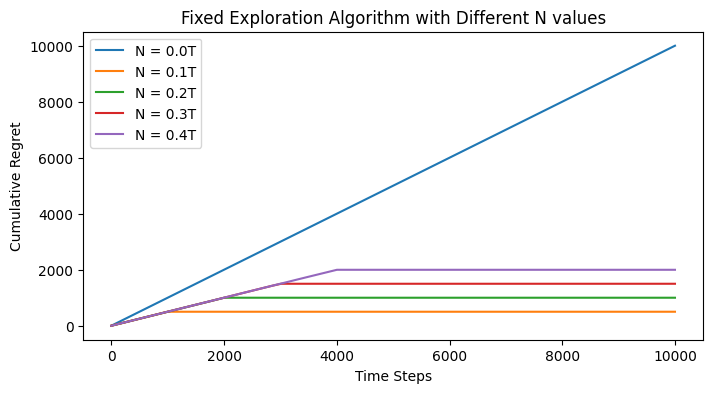

In [2]:
# ==========================
# Fixed Exploration with N = fraction of T
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
# reward_means = np.random.rand(num_arms)
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000
num_experiments = 100  # Number of experiments to average over

# Plot setup
plt.figure(figsize=(8,4))

# Run and plot Fixed Exploration Then Exploitation
fractions = np.arange(0.0, 0.5, 0.1)
for frac in fractions:
    N = int(frac * num_steps)
    fixed_exploration_regret = run_multiple_experiments(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': N},
                                                        env, num_steps, num_experiments)
    plt.plot(fixed_exploration_regret, label=f'N = {frac:.1f}T')

plt.title("Fixed Exploration Algorithm with Different N values")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_13582/3013914866.py:17: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(epsilon_greedy_regret, label=f'$\epsilon = $ {ep:.1f}')
/tmp/ipykernel_13582/3013914866.py:21: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Epsilon-Greedy with Constant $\epsilon$")


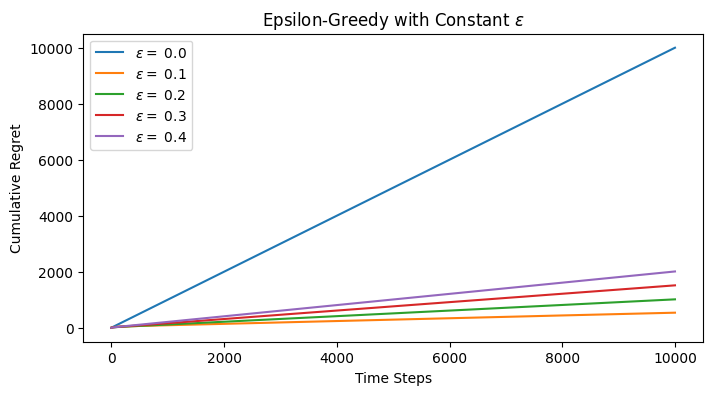

In [3]:
# ==========================
# Epsilon-Greedy with constant epsilon
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced expected rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000
num_experiments = 100  # Number of experiments to average over

# Plot setup
plt.figure(figsize=(8,4))

epsilons = np.arange(0.0, 0.5, 0.1)
for ep in epsilons:
    epsilon_greedy_regret = run_multiple_experiments(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': ep},
                                                     env, num_steps, num_experiments)
    plt.plot(epsilon_greedy_regret, label=f'$\epsilon = $ {ep:.1f}')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("Epsilon-Greedy with Constant $\epsilon$")
plt.legend()
plt.show()

In [4]:
# Define epsilon schedule
def epsilon_schedule_1(t):
    return 1 / (t + 1)

def epsilon_schedule_2(t):
    return 1 / np.sqrt(t + 1)

def epsilon_schedule_3(t):
    return np.log(t + 1) / (t + 1) 

<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:15: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_13582/3059168001.py:15: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_title("Decaying rate of $\epsilon$")
/tmp/ipykernel_13582/3059168001.py:19: SyntaxWarning: invalid escape sequence '\e'
  ax[0].plot(1 / time_steps, 'b-', label='$\epsilon = 1/t$')
/tmp/ipyke

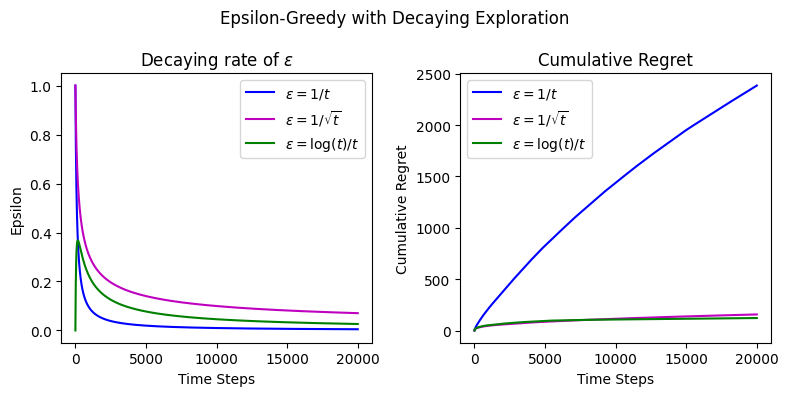

In [5]:
# ==========================
# Epsilon-Greedy with decaying epsilon
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced expected rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 20000
num_experiments = 100  # Number of experiments to average over

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].set(xlabel="Time Steps", ylabel="Epsilon")
ax[1].set(xlabel="Time Steps", ylabel="Cumulative Regret")

plt.suptitle("Epsilon-Greedy with Decaying Exploration")
ax[0].set_title("Decaying rate of $\epsilon$")
ax[1].set_title("Cumulative Regret")

time_steps = np.linspace(1, 0.01 * num_steps, num_steps)
ax[0].plot(1 / time_steps, 'b-', label='$\epsilon = 1/t$')
ax[0].plot(1 / np.sqrt(time_steps), 'm-', label='$\epsilon = 1/\sqrt{t}$')
ax[0].plot(np.log(time_steps) / time_steps, 'g-', label='$\epsilon = \log(t)/t$')


regret_1 = run_multiple_experiments(EpsilonGreedyDecaying, 
                                    {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_1},
                                    env, num_steps, num_experiments)
ax[1].plot(regret_1, 'b-', label='$\epsilon = 1/t$')

regret_2 = run_multiple_experiments(EpsilonGreedyDecaying, 
                                    {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_2},
                                    env, num_steps, num_experiments)
ax[1].plot(regret_2, 'm-', label='$\epsilon = 1/\sqrt{t}$')

regret_3 = run_multiple_experiments(EpsilonGreedyDecaying, 
                                    {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_3},
                                    env, num_steps, num_experiments)
ax[1].plot(regret_3, 'g-', label='$\epsilon = \log(t)/t$')

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()


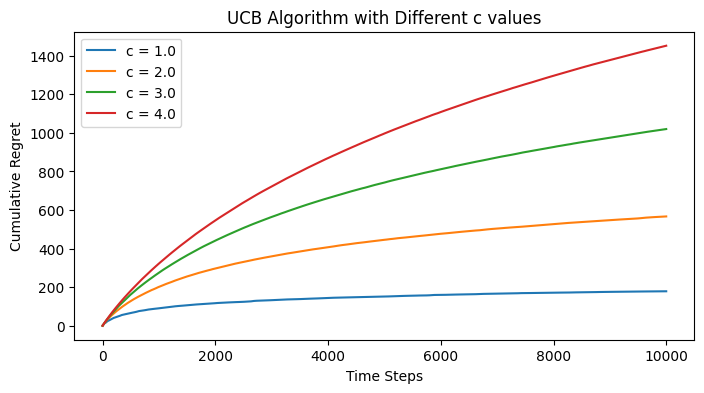

In [6]:
# ==========================
# UCB with different c values
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
# reward_means = np.random.rand(num_arms)
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000
num_experiments = 100  # Number of experiments to average over

# Plot setup
plt.figure(figsize=(8,4))

# c_values = np.arange(0.1, 0.9, 0.2)
c_values = np.arange(1, 5, 1)

for c in c_values:
    ucb_regret = run_multiple_experiments(UCB, {'num_arms': num_arms, 'c': c},
                                          env, num_steps, num_experiments)
    plt.plot(ucb_regret, label=f'c = {c:.1f}')

plt.title("UCB Algorithm with Different c values")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()

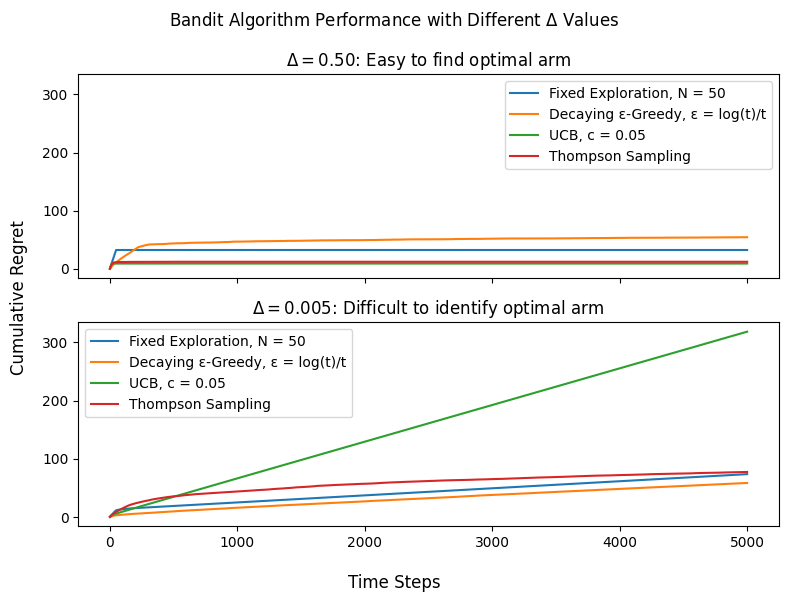

In [7]:
# ==========================
# Sensitivity Analysis:
# Algorithms' performance with different Delta
# ==========================

num_arms = 10
num_steps = 5000
num_experiments = 10
N = int(num_steps * 0.01)
epsilon = 0.1
c = 0.05

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

###############################################
# Top Plot: Δ = 0.50: Optimal arm easily identified
###############################################
# Set best arm = 1.0 and second best = 0.5; remaining arms from [0, 0.49]
reward_means = np.concatenate((np.array([1.0, 0.5]),
                               np.random.uniform(0, 0.49, size=num_arms - 2)))
env = BanditEnvironment(num_arms, reward_means)
best_mean = max(reward_means)
second_best_mean = np.sort(reward_means)[-2]
Delta = best_mean - second_best_mean

# Run algorithms using multiple experiments
fixed_exploration_regret = run_multiple_experiments(
    FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': N},
    env, num_steps, num_experiments)
ax[0].plot(fixed_exploration_regret, label=f'Fixed Exploration, N = {N}')

decaying_epsilon_greedy_regret = run_multiple_experiments(
    EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_3},
    env, num_steps, num_experiments)
ax[0].plot(decaying_epsilon_greedy_regret, label='Decaying ε-Greedy, ε = log(t)/t')

ucb_regret = run_multiple_experiments(
    UCB, {'num_arms': num_arms, 'c': c},
    env, num_steps, num_experiments)
ax[0].plot(ucb_regret, label=f'UCB, c = {c}')

thompson_regret = run_multiple_experiments(
    ThompsonSampling, {'num_arms': num_arms},
    env, num_steps, num_experiments)
ax[0].plot(thompson_regret, label='Thompson Sampling')

ax[0].set_title("$\\Delta = 0.50$: Easy to find optimal arm")
ax[0].legend()


###############################################
# Bottom Plot: Δ = 0.005: Difficult to identify optimal arm
###############################################
# Set best arm = 0.505 and second best = 0.500; remaining arms from [0, 0.49]
reward_means = np.concatenate((np.array([0.505, 0.500]),
                               np.random.uniform(0, 0.49, size=num_arms - 2)))
env = BanditEnvironment(num_arms, reward_means)
best_mean = max(reward_means)
second_best_mean = np.sort(reward_means)[-2]
Delta = best_mean - second_best_mean

fixed_exploration_regret = run_multiple_experiments(
    FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': N},
    env, num_steps, num_experiments)
ax[1].plot(fixed_exploration_regret, label=f'Fixed Exploration, N = {N}')

decaying_epsilon_greedy_regret = run_multiple_experiments(
    EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_3},
    env, num_steps, num_experiments)
ax[1].plot(decaying_epsilon_greedy_regret, label='Decaying ε-Greedy, ε = log(t)/t')

ucb_regret = run_multiple_experiments(
    UCB, {'num_arms': num_arms, 'c': c},
    env, num_steps, num_experiments)
ax[1].plot(ucb_regret, label=f'UCB, c = {c}')

thompson_regret = run_multiple_experiments(
    ThompsonSampling, {'num_arms': num_arms},
    env, num_steps, num_experiments)
ax[1].plot(thompson_regret, label='Thompson Sampling')

ax[1].set_title("$\\Delta = 0.005$: Difficult to identify optimal arm")
ax[1].legend()

fig.supxlabel("Time Steps")
fig.supylabel("Cumulative Regret")
plt.suptitle("Bandit Algorithm Performance with Different $\\Delta$ Values")
plt.tight_layout()
plt.show()


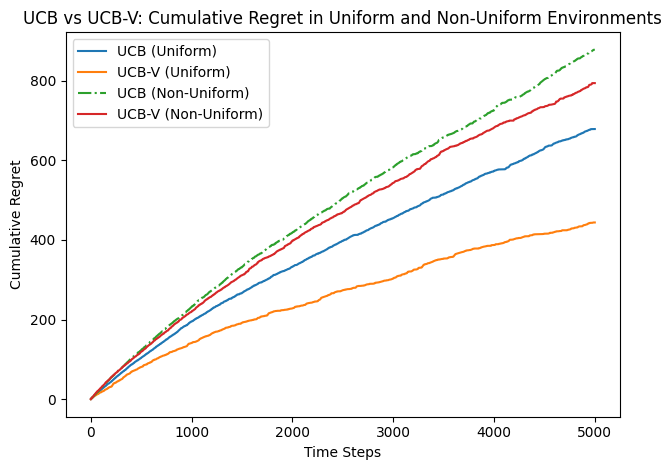

In [8]:
# ==========================
# UCB-V
# ==========================

class UCB_V:
    def __init__(self, num_arms, c=2):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.squared_values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.num_arms:
            return self.t - 1
        ucb_values = np.zeros(self.num_arms)
        for i in range(self.num_arms):
            mean = self.values[i]
            count = self.counts[i]
            variance = self.squared_values[i] / count - mean ** 2 if count > 0 else 0
            bonus = self.c * np.sqrt((2 * np.log(self.t) * max(variance, 1e-6)) / count)
            bonus += (3 * np.log(self.t)) / count
            ucb_values[i] = mean + bonus
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.squared_values[arm] += reward ** 2
        self.t += 1

# ==========================
# NEW: UCB vs UCB-V using initial uniform rewards
# ==========================
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
ucbv_regret = run_experiment(UCB_V, {'num_arms': num_arms, 'c': 4}, env, num_steps)

ucb_regret_uniform = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
ucbv_regret_uniform = run_experiment(UCB_V, {'num_arms': num_arms, 'c': 4}, env, num_steps)

# ==========================
# NEW: Non-uniform reward means for realistic setup
# ==========================
reward_means_non_uniform = np.array([0.1, 0.15, 0.3, 0.25, 0.5, 0.55, 0.4, 0.45, 0.7, 0.65])
env_non_uniform = BanditEnvironment(num_arms, reward_means_non_uniform)

# ==========================
# NEW: Compare UCB and UCB-V under non-uniform reward distribution
# ==========================
ucb_regret_nu = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env_non_uniform, num_steps)
ucbv_regret_nu = run_experiment(UCB_V, {'num_arms': num_arms, 'c': 4}, env_non_uniform, num_steps)

# Uniform reward setting
plt.plot(ucb_regret_uniform, label='UCB (Uniform)', linestyle='-')
plt.plot(ucbv_regret_uniform, label='UCB-V (Uniform)', linestyle='-')

# Non-uniform reward setting
plt.plot(ucb_regret_nu, label='UCB (Non-Uniform)', linestyle='-.')
plt.plot(ucbv_regret_nu, label='UCB-V (Non-Uniform)', linestyle='-')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("UCB vs UCB-V: Cumulative Regret in Uniform and Non-Uniform Environments")
plt.legend()
plt.tight_layout()
plt.show()